# Article Relevance Prediction for NeotomaDB
## Model Iterations with Word Embeddings

This notebook contains the following tasks:
1. Import cleaned data from "../data/processed/metadata_processed.csv"
2. Add word embeddings
3. Train-Test split
4. Feature Selection
5. Hyperparameter tuning (with MLflow tracking)
6. Best Model

# 1. Import Data

In [1]:
import numpy as np
import pandas as pd
import os
from dotenv import load_dotenv, find_dotenv
import mlflow
import azureml
from mlflow.models.signature import infer_signature

load_dotenv(find_dotenv())

AZURE_MLFLOW_URI = os.environ.get("AZURE_MLFLOW_URI")
mlflow.set_tracking_uri(AZURE_MLFLOW_URI)

#### Create Training and Testing Data for Model Iteration 1 

In [2]:
import numpy as np
import pandas as pd
metadata_df = pd.read_csv("../data/processed/metadata_processed.csv")
metadata_df.columns

Index(['Unnamed: 0', 'DOI', 'URL', 'abstract', 'author', 'container-title',
       'is-referenced-by-count', 'language', 'published', 'publisher',
       'subject', 'subtitle', 'title', 'target', 'published_year',
       'title_clean', 'subtitle_clean', 'abstract_clean', 'subject_clean',
       'has_abstract', 'text_with_abstract', 'text_wo_abstract', 'detectlang'],
      dtype='object')

In [3]:
training_keepcol = [
       'is-referenced-by-count', 
       'has_abstract', 
       'subject_clean',
       'text_with_abstract', 
       'target']

metadata_df_cleaned = metadata_df.loc[:, training_keepcol]

metadata_df_cleaned.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4435 entries, 0 to 4434
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   is-referenced-by-count  4435 non-null   int64 
 1   has_abstract            4435 non-null   int64 
 2   subject_clean           4346 non-null   object
 3   text_with_abstract      4435 non-null   object
 4   target                  4435 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 173.4+ KB


In [4]:
#empty strings being imported as NaN's, so filling with empty strings
metadata_df_cleaned['subject_clean'] = metadata_df_cleaned['subject_clean'].fillna(value='')

# 2. Add Sentance Embeddings

> !pip install sentence_transformers

In [5]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('allenai/specter2')

No sentence-transformers model found with name /Users/kw/.cache/torch/sentence_transformers/allenai_specter2. Creating a new one with MEAN pooling.


In [6]:
# Create sentance embeddings
embeddings = metadata_df_cleaned['text_with_abstract'].apply(model.encode)

In [9]:
embeddings_formatted = pd.DataFrame(embeddings.tolist())
embeddings_formatted

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,-0.367841,-0.682618,0.481659,-0.076614,1.361158,-0.055952,0.724120,0.029236,-0.371343,0.208466,...,-0.043954,0.052891,0.146780,-1.735587,-0.043915,-0.297620,0.090835,0.194451,-0.420138,-0.231142
1,0.436005,0.040026,-0.203677,-0.304372,0.277975,0.072686,0.762866,0.811004,-0.300561,0.721993,...,-0.302171,-0.684025,0.423019,-1.777156,0.134475,-0.994175,0.069995,0.323936,0.398270,-0.962721
2,0.744607,-0.652021,-0.380955,0.007732,0.814745,0.259691,0.131211,-0.164518,0.045866,0.564709,...,-0.041242,0.003290,0.151888,-1.156450,-0.571584,-0.730974,-0.192784,-0.371344,0.129544,-0.870950
3,0.114701,-0.218918,-0.305862,0.614540,0.312255,-0.054838,0.108858,0.566724,-0.105552,0.201352,...,0.097129,-0.540970,-0.165240,-0.534668,-0.509150,-0.612954,-0.172338,-0.157656,-0.290807,-0.581540
4,-0.056214,-0.403606,-0.136764,0.089092,1.015412,0.202195,0.999896,0.329975,-0.535107,0.656730,...,-0.054828,-0.227087,0.086429,-0.868923,-0.564220,-1.107351,-0.470971,0.183784,0.100971,-0.944220
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4430,0.339417,0.101199,-0.458718,0.058226,0.759643,-0.291644,0.643178,0.593418,-0.088356,-0.144444,...,-0.083288,-0.187606,0.160323,-0.668525,-0.386127,-0.943945,-0.193551,0.228726,-0.383796,-0.855458
4431,0.269436,-0.041214,0.302663,0.339386,0.111603,-0.455084,-0.111151,1.140449,-0.013668,-0.019977,...,0.135322,0.304750,0.686558,-0.649246,-0.523400,-0.502265,-0.724967,0.285527,-0.024432,-0.772663
4432,0.319937,-0.013901,0.332743,0.412342,0.308393,-0.295955,0.754990,0.423491,-0.381034,0.210434,...,-0.444082,-0.698346,0.242722,-1.255496,-0.090500,-0.399208,-0.166269,-0.041473,-0.598962,-0.606830
4433,-0.070910,-0.745114,-0.032809,0.515964,0.676877,-0.072093,0.420317,0.511388,-0.044020,0.234968,...,-0.007636,0.587618,0.460993,-0.659403,-0.442102,-0.274008,0.179789,-0.276637,-0.229170,-0.824705


In [10]:
#save embeddings
embeddings_formatted.to_csv("../data/processed/embeddings.csv")

In [6]:
# Read From Dataframe
embeddings_df = pd.read_csv("../data/processed/embeddings.csv", index_col=0)
embeddings_df.columns = embeddings_df.columns.astype(str) # require column names as strings for modelling
embeddings_df

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,-0.367841,-0.682618,0.481659,-0.076614,1.361158,-0.055952,0.724120,0.029236,-0.371343,0.208466,...,-0.043954,0.052891,0.146780,-1.735587,-0.043915,-0.297620,0.090835,0.194451,-0.420138,-0.231142
1,0.436005,0.040026,-0.203677,-0.304372,0.277975,0.072686,0.762866,0.811004,-0.300561,0.721993,...,-0.302171,-0.684025,0.423019,-1.777157,0.134475,-0.994175,0.069995,0.323936,0.398270,-0.962721
2,0.744607,-0.652021,-0.380955,0.007732,0.814745,0.259691,0.131211,-0.164518,0.045866,0.564709,...,-0.041242,0.003290,0.151888,-1.156450,-0.571584,-0.730974,-0.192784,-0.371344,0.129544,-0.870950
3,0.114701,-0.218918,-0.305862,0.614540,0.312255,-0.054838,0.108858,0.566724,-0.105552,0.201352,...,0.097129,-0.540970,-0.165240,-0.534668,-0.509150,-0.612954,-0.172338,-0.157656,-0.290807,-0.581540
4,-0.056214,-0.403606,-0.136764,0.089092,1.015412,0.202195,0.999896,0.329975,-0.535107,0.656730,...,-0.054828,-0.227087,0.086429,-0.868923,-0.564220,-1.107351,-0.470971,0.183784,0.100971,-0.944220
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4430,0.339417,0.101199,-0.458718,0.058226,0.759644,-0.291644,0.643178,0.593418,-0.088356,-0.144444,...,-0.083288,-0.187606,0.160323,-0.668525,-0.386127,-0.943945,-0.193551,0.228726,-0.383796,-0.855458
4431,0.269436,-0.041214,0.302663,0.339386,0.111603,-0.455084,-0.111151,1.140449,-0.013668,-0.019977,...,0.135322,0.304750,0.686558,-0.649246,-0.523401,-0.502265,-0.724967,0.285527,-0.024432,-0.772663
4432,0.319937,-0.013901,0.332743,0.412342,0.308393,-0.295955,0.754990,0.423491,-0.381034,0.210434,...,-0.444082,-0.698346,0.242723,-1.255496,-0.090500,-0.399208,-0.166269,-0.041473,-0.598962,-0.606830
4433,-0.070910,-0.745114,-0.032809,0.515964,0.676877,-0.072093,0.420317,0.511388,-0.044020,0.234968,...,-0.007636,0.587618,0.460993,-0.659403,-0.442102,-0.274008,0.179789,-0.276637,-0.229170,-0.824705


In [7]:
# Joining embeddings to DataFrame
metadata_df_cleaned = pd.concat([metadata_df_cleaned, embeddings_df], axis = 1)
metadata_df_cleaned.columns

Index(['is-referenced-by-count', 'has_abstract', 'subject_clean',
       'text_with_abstract', 'target', '0', '1', '2', '3', '4',
       ...
       '758', '759', '760', '761', '762', '763', '764', '765', '766', '767'],
      dtype='object', length=773)

# 3. Train-Test Split

In [8]:
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_validate,
    cross_val_score,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline

In [9]:
train_df, val_test_df = train_test_split(metadata_df_cleaned, test_size=0.3, random_state=123)
valid_df, test_df = train_test_split(val_test_df, test_size=0.5, random_state=123)

train_df.head()

,is-referenced-by-count,has_abstract,subject_clean,text_with_abstract,target,0,1,2,3,4,...,758,759,760,761,762,763,764,765,766,767
2939,0,0,"Genetics Ecology, Evolution, Behavior and Syst...",Taxonomic and functional dynamics during chytr...,0,0.440054,-0.004341,0.447340,0.546970,0.960488,...,-0.462889,-0.187888,0.203939,-1.489427,0.058993,-0.244155,-0.406988,0.107807,-0.596005,-0.523304
1668,1,1,Religious studies Visual Arts and Performing Arts,"Space, place, and religious meaning",0,-0.084764,0.297758,0.384933,-0.260337,0.575293,...,-0.322636,0.378663,-0.009457,-0.815779,-0.773078,-0.399045,-0.463382,0.328713,-0.047278,-0.576225
2297,1,1,Computational Mathematics Organic Chemistry Bi...,Publisher's Note: Abstraction for data integra...,0,0.152081,0.368462,-0.230470,0.026909,0.071763,...,-0.739739,0.517700,0.739704,-1.021186,-0.093548,-0.206341,-0.406670,-0.261074,0.194641,-0.273539
1955,48,1,"Management, Monitoring, Policy and Law Waste M...",No perfect tools: Trade-offs of sustainability...,0,0.220465,0.283834,-0.155840,0.139376,0.871750,...,-0.307471,-0.590513,-0.236310,-0.897312,-0.511457,-1.088740,-0.276451,-0.385275,-0.137181,-0.820704
4222,6,0,Multidisciplinary,"Maritime Paleoindian technology, subsistence, ...",0,0.579186,-0.092632,-0.111798,0.193873,0.229161,...,-0.260911,-0.537787,0.293415,-0.576466,-0.481050,-0.332881,-0.605197,-0.119935,-0.106829,-0.556662


In [18]:
print(train_df.shape, valid_df.shape, test_df.shape)

(3104, 773) (665, 773) (666, 773)


### EDA for Train Split

In [10]:
train_df.sort_index()
train_df.info() # check non-null 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3104 entries, 2939 to 3582
Columns: 773 entries, is-referenced-by-count to 767
dtypes: float64(768), int64(3), object(2)
memory usage: 18.3+ MB


In [11]:
pos_df = train_df[train_df["target"] == 1]
neg_df = train_df[train_df["target"] == 0]

In [12]:
print("With Abstract")
sorted_pos_df = pos_df.reindex(pos_df.text_with_abstract.str.len().sort_values().index)
sorted_neg_df = neg_df.reindex(neg_df.text_with_abstract.str.len().sort_values().index)
avg_pos_len = pos_df.text_with_abstract.str.len().mean()
avg_neg_len = neg_df.text_with_abstract.str.len().mean()
print(avg_pos_len)
print(avg_neg_len)

With Abstract
716.2927215189874
860.9178802588997


In [13]:
# sorted_pos_df.head()

In [14]:
# sorted_neg_df.head()

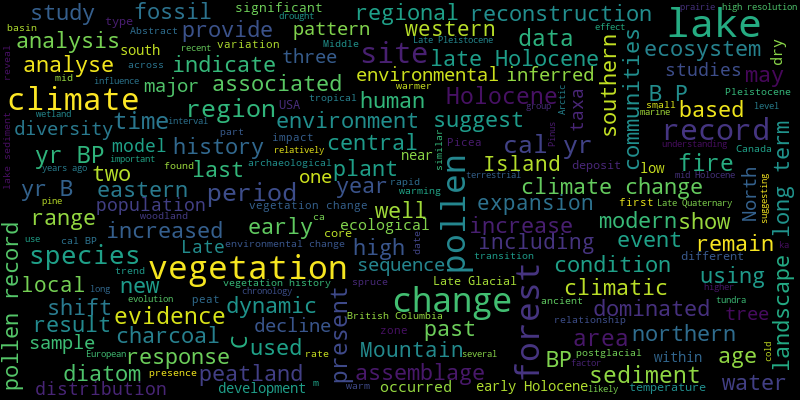

In [15]:
from wordcloud import WordCloud

pos_text = " ".join(train_df[train_df["target"] == 1]["text_with_abstract"].tolist())
neg_text = " ".join(train_df[train_df["target"] == 0]["text_with_abstract"].tolist())

wordcloud = WordCloud(max_font_size=40, width=800, height=400)
wordcloud.generate(pos_text).to_image()

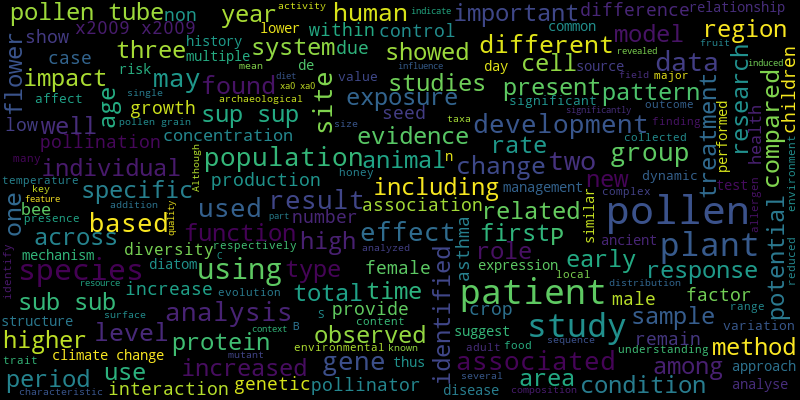

In [16]:
wordcloud.generate(neg_text).to_image()

#### Examine class distribution in train split

In [17]:
train_df["target"].value_counts(normalize=True)

0    0.796392
1    0.203608
Name: target, dtype: float64

# 4. Modelling with Sentence Embeddings

### 4.1 Preprocessor

In [19]:
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_validate,
    cross_val_score,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline

In [20]:
train_df.columns

Index(['is-referenced-by-count', 'has_abstract', 'subject_clean',
       'text_with_abstract', 'target', '0', '1', '2', '3', '4',
       ...
       '758', '759', '760', '761', '762', '763', '764', '765', '766', '767'],
      dtype='object', length=773)

In [21]:
X_train, y_train = train_df.drop(columns = ["target", "text_with_abstract"]), train_df["target"]
X_valid, y_valid = valid_df.drop(columns = ["target", "text_with_abstract"]), valid_df["target"]
X_test, y_test = test_df.drop(columns = ["target", "text_with_abstract"]), test_df["target"]

In [22]:
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder, FunctionTransformer

# Dividing the feature types
text_features = "subject_clean"
text_transformer = CountVectorizer(stop_words="english", max_features= 1000)

binary_feature = ['has_abstract']
binary_transformer = OneHotEncoder(drop='if_binary', dtype = int)

numeric_features = ["is-referenced-by-count"]
numeric_transformer = StandardScaler()

# Create the column transformer
preprocessor = ColumnTransformer(
    transformers = [
    ("num_preprocessor", numeric_transformer, numeric_features),
    ("binary_preprocessor", binary_transformer, binary_feature),
    ("text_preprocessor", text_transformer, text_features)
    ],
    remainder = "passthrough"
)

preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('num_preprocessor', StandardScaler(),
                                 ['is-referenced-by-count']),
                                ('binary_preprocessor',
                                 OneHotEncoder(drop='if_binary',
                                               dtype=<class 'int'>),
                                 ['has_abstract']),
                                ('text_preprocessor',
                                 CountVectorizer(max_features=1000,
                                                 stop_words='english'),
                                 'subject_clean')])

##### Check Transformed Data

In [23]:
transformed_X_train = preprocessor.fit_transform(X_train)
transformed_X_train

array([[-0.38349436,  0.        ,  0.        , ...,  0.10780669,
        -0.5960055 , -0.5233035 ],
       [-0.357678  ,  1.        ,  0.        , ...,  0.32871324,
        -0.04727843, -0.576225  ],
       [-0.357678  ,  1.        ,  0.        , ..., -0.26107374,
         0.19464079, -0.27353862],
       ...,
       [-0.38349436,  1.        ,  0.        , ..., -0.12497892,
         0.10995826, -0.37614492],
       [-0.38349436,  0.        ,  0.        , ..., -0.26709256,
        -0.10828786, -1.0894089 ],
       [-0.38349436,  0.        ,  0.        , ...,  0.04213829,
         0.1705434 , -0.72560143]])

In [24]:
col_names = (preprocessor.named_transformers_["num_preprocessor"].get_feature_names_out().tolist() +
             preprocessor.named_transformers_["binary_preprocessor"].get_feature_names_out().tolist() + 
             preprocessor.named_transformers_["text_preprocessor"].get_feature_names_out().tolist() + 
             embeddings_df.columns.tolist())
len(col_names)

1089

In [25]:
transformed_X_train_df = pd.DataFrame(transformed_X_train, columns=col_names)
transformed_X_train_df.head(3)

,is-referenced-by-count,has_abstract_1,accounting,administration,advanced,aerospace,aging,agricultural,agronomy,aided,...,758,759,760,761,762,763,764,765,766,767
0,-0.383494,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.462889,-0.187888,0.203939,-1.489427,0.058993,-0.244155,-0.406988,0.107807,-0.596005,-0.523304
1,-0.357678,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.322636,0.378663,-0.009457,-0.815779,-0.773078,-0.399045,-0.463382,0.328713,-0.047278,-0.576225
2,-0.357678,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.739739,0.517700,0.739704,-1.021186,-0.093548,-0.206341,-0.406670,-0.261074,0.194641,-0.273539


### 4.2 Model Comparison

In [26]:
from sklearn.linear_model import LogisticRegression 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB, GaussianNB, MultinomialNB
from lightgbm.sklearn import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier, HistGradientBoostingClassifier

In [27]:
# Helper function for comparing models
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns pandas Series with mean and std of cross validation
    """
    scores = cross_validate(model, X_train, y_train, **kwargs)
    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []
    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))
    return pd.Series(data=out_col, index=mean_scores.index)

In [29]:
classification_metrics = ["f1", "precision", "recall", "accuracy"]

In [31]:
results_dict = {}
# models = {
# 	"dummy": DummyClassifier(random_state = 123),
#   "logistic regression": LogisticRegression(max_iter=1000, random_state=123),
#     "decision tree": DecisionTreeClassifier(random_state=123, max_depth=200),
#     "kNN": KNeighborsClassifier(),
#     'NaiveBayes': BernoulliNB(alpha=1),
#     "RBF SVM": SVC(random_state=123),
#     'RF': RandomForestClassifier(class_weight="balanced", random_state=123),
#     'LGBM': LGBMClassifier(random_state=123),
#     'Cat Boost': CatBoostClassifier(verbose=0, random_state=123),
#     'XGB' : XGBClassifier(random_state=123, verbosity=0),
#     'sklearn_histGB': HistGradientBoostingClassifier(random_state=123),
#     "sklearn_GB": GradientBoostingClassifier(random_state=123)
#     }

models = {
	"dummy": DummyClassifier(random_state = 123),
    'Logistic Regression': LogisticRegression(class_weight="balanced", max_iter=1000, random_state=123),
    "Decision Tree": DecisionTreeClassifier(class_weight="balanced", random_state=123, max_depth=200),
    "kNN": KNeighborsClassifier(),
    'Naive Bayes': BernoulliNB(),
    "RBF SVM": SVC(class_weight="balanced", random_state=123),
    'RF': RandomForestClassifier(class_weight="balanced", random_state=123),
    'LGBM': LGBMClassifier(class_weight="balanced", random_state=123),
    # 'CatBoost': CatBoostClassifier(verbose=0, random_state=123),
    'XGBoost': XGBClassifier(class_weight="balanced", random_state=123, verbosity=0),
    'sklearn_histGB': HistGradientBoostingClassifier(random_state=123),
    'sklearn_GB': GradientBoostingClassifier(random_state=123)
    }

for key, model in models.items():
    pipe = make_pipeline(preprocessor, model)
    results_dict[key] = mean_std_cross_val_scores(pipe, X_train, y_train, cv=5, return_train_score=True, scoring=classification_metrics)

results_df = pd.DataFrame(results_dict).T
results_df


/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-pack

KeyboardInterrupt: 

##### Summary of models
- Naive Bayes has the highest test recall but the precision is too low and will introduce many false positives.
- sklearn_GB and CatBoost has high f1 but their fit time is very long - not practical
- logistic regression and LGBM has high recall, f1 and reasonable fit time and precision

### 4.3 Logistic Regression Model Evaluation

##### Logistic Regression

In [27]:
from sklearn.linear_model import LogisticRegression 

# The model pipeline

logreg_model = make_pipeline(preprocessor, LogisticRegression(max_iter=1000, random_state=123))

# The mean and std of the cross validated scores for all metrics as a dataframe

classification_metrics = ["accuracy", "precision", "recall", "f1"]

cross_val_results= {}
cross_val_results['logreg'] = pd.DataFrame(
    cross_validate(
        logreg_model,
        X_train,
        y_train,
        scoring=classification_metrics,
        return_train_score=True
    )
).agg(['mean', 'std']).round(3).T

cross_val_results['logreg']

,mean,std
fit_time,1.079,0.087
score_time,0.033,0.005
test_accuracy,0.967,0.004
train_accuracy,0.996,0.001
test_precision,0.934,0.012
train_precision,0.995,0.003
test_recall,0.904,0.009
train_recall,0.985,0.004
test_f1,0.919,0.009
train_f1,0.990,0.002


In [ ]:
logreg_model.named_steps['logisticregression'].param

##### Feature importance for Logistic Regression

In [28]:
model_params = logreg_model.named_steps['logisticregression'].get_params()
model_params

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 1000,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 123,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [29]:
logreg_model.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_preprocessor',
                                                  StandardScaler(),
                                                  ['is-referenced-by-count']),
                                                 ('binary_preprocessor',
                                                  OneHotEncoder(drop='if_binary',
                                                                dtype=<class 'int'>),
                                                  ['has_abstract']),
                                                 ('text_preprocessor',
                                                  CountVectorizer(max_features=1000,
                                                                  stop_words='english'),
                                                  'subject_clean')])),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, random_state=123))])

In [30]:
data = {
    "coefficient": logreg_model.named_steps['logisticregression'].coef_.flatten().tolist(),
    "magnitude": np.absolute(
        logreg_model.named_steps['logisticregression'].coef_.flatten().tolist()
    ),
}
coef_df = pd.DataFrame(data, index=col_names).sort_values(
    "magnitude", ascending=False
)

# Top 30 features contributing for positive class
coef_df.query('coefficient > 0').head(30)

,coefficient,magnitude
archeology,1.409828,1.409828
paleontology,0.945548,0.945548
732,0.907300,0.907300
110,0.899695,0.899695
581,0.888129,0.888129
573,0.801779,0.801779
155,0.795223,0.795223
180,0.793460,0.793460
532,0.785945,0.785945
350,0.769437,0.769437


In [31]:
# Top 30 features contributing for negative class
coef_df.query('coefficient < 0').head(30)

,coefficient,magnitude
multidisciplinary,-1.426207,1.426207
718,-1.049860,1.049860
55,-0.979836,0.979836
761,-0.945828,0.945828
561,-0.804155,0.804155
37,-0.795770,0.795770
393,-0.774409,0.774409
537,-0.767976,0.767976
202,-0.766721,0.766721
175,-0.739919,0.739919


In [32]:
from sklearn.metrics import recall_score
# Make predictions
predictions = logreg_model.predict(X_train)

# Add the predictions to the original DataFrame
train_df['predictions'] = predictions

# Group the data by a specific feature
grouped_data = train_df.groupby('has_abstract')

# Calculate recall for each group
grouped_recall = grouped_data.apply(lambda x: recall_score(x['target'], x['predictions']))

# Print the recall by group
print(grouped_recall)

has_abstract
0    0.96
1    1.00
dtype: float64


##### Model Mistakes

In [33]:
logreg_model.fit(X_train, y_train)

train_df['y_pred'] = logreg_model.predict(X_train)
# train_df['y_predictproba'] = logreg_model.predict_proba(X_train)

train_df.head(5)

# False Positives
train_df.query('target == 0 & y_pred == 1')

# False Negative
train_df.query('target == 1 & y_pred == 0')

,is-referenced-by-count,has_abstract,subject_clean,text_with_abstract,text_wo_abstract,target,0,1,2,3,...,760,761,762,763,764,765,766,767,predictions,y_pred
3372,12,0,"Library and Information Sciences Statistics, P...","p3k14c, a synthetic global database of archaeo...","p3k14c, a synthetic global database of archaeo...",1,0.213396,0.042437,0.097543,-0.164637,...,0.407151,-0.878209,-0.153351,-0.412318,-0.453711,-0.170426,0.240408,-1.037293,0,0
3397,0,0,Plant Science,Fossil pollen resolves origin of the South Afr...,Fossil pollen resolves origin of the South Afr...,1,0.799007,0.072415,0.167970,-0.102467,...,0.315138,-0.389148,0.214993,-0.946495,-0.506958,0.467604,0.129413,-0.569880,0,0
2536,0,0,Multidisciplinary,“Well” off in animals: A taphonomic history of...,“Well” off in animals: A taphonomic history of...,1,0.132057,0.247640,0.273822,0.165507,...,0.391908,-0.688703,-0.699732,-0.361962,-0.510942,-0.231760,-0.395011,-0.694757,0,0
3558,12,0,General Immunology and Microbiology General Bi...,Ancient DNA reveals the lost domestication his...,Ancient DNA reveals the lost domestication his...,1,0.489508,0.347412,0.127197,-0.016068,...,0.558301,-0.782260,-0.180607,-0.298737,-0.501164,-0.121281,-0.218225,-0.662976,0,0
3447,3,0,"Anthropology Ecology, Evolution, Behavior and ...",Evidence of habitual behavior from non-aliment...,Evidence of habitual behavior from non-aliment...,1,0.587087,0.853532,0.035451,-0.173374,...,0.318171,-1.114613,-0.662820,-0.602304,-0.060114,-0.384035,-0.239291,-0.584039,0,0
3905,36,0,Multidisciplinary,The Emergence of Animal Management in the Sout...,The Emergence of Animal Management in the Sout...,1,0.438775,0.416888,0.103239,-0.139776,...,0.280307,-0.551912,-0.379107,-0.712601,-0.623073,-0.005573,0.045461,-0.601610,0,0
4106,62,0,Multidisciplinary,Identifying early modern human ecological nich...,Identifying early modern human ecological nich...,1,0.583869,-0.080542,0.205314,0.090711,...,0.385519,-0.605621,-0.154782,-0.611014,-0.315918,0.027246,0.193550,-0.833747,0,0
3592,18,0,Multidisciplinary,Living off the land: Terrestrial-based diet an...,Living off the land: Terrestrial-based diet an...,1,0.409894,0.409192,0.099977,0.083620,...,0.353856,-0.745450,-0.831885,-0.723577,-0.249806,-0.109471,-0.005812,-0.713384,0,0
2616,32,0,Multidisciplinary,Dire wolves were the last of an ancient New Wo...,Dire wolves were the last of an ancient New Wo...,1,0.120220,0.490394,0.118549,-0.317582,...,0.367878,-0.400605,0.017071,-0.228756,-0.401369,0.227250,-0.083113,-0.571556,0,0
4033,19,0,"Health, Toxicology and Mutagenesis Pollution E...",Phytoplankton functional groups in a monomicti...,Phytoplankton functional groups in a monomicti...,1,-0.059075,-0.369456,0.463117,0.491769,...,-0.068452,-1.347685,-0.328752,-0.619133,-0.431279,-0.047673,-0.920533,-0.608456,0,0


### 4.4 Feature Selection

In [37]:
from sklearn.feature_selection import SelectFromModel

for name, model in models.items():
    pipe = make_pipeline(
        preprocessor,
        SelectFromModel(
            LogisticRegression(solver="liblinear", penalty="l1", max_iter=1000)
        ),
        model,
    )
    results_dict[name + "+ feat_sel"] = mean_std_cross_val_scores(
        pipe, X_train, y_train, return_train_score=True, scoring=classification_metrics
    )

In [38]:
pd.DataFrame(results_dict).T

,fit_time,score_time,test_accuracy,train_accuracy,test_precision,train_precision,test_recall,train_recall,test_f1,train_f1
dummy,0.071 (+/- 0.005),0.027 (+/- 0.002),0.794 (+/- 0.001),0.794 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000)
logistic regression,1.150 (+/- 0.261),0.033 (+/- 0.013),0.967 (+/- 0.004),0.996 (+/- 0.001),0.934 (+/- 0.012),0.995 (+/- 0.003),0.904 (+/- 0.009),0.985 (+/- 0.004),0.919 (+/- 0.009),0.990 (+/- 0.002)
decision tree,3.496 (+/- 0.129),0.021 (+/- 0.004),0.908 (+/- 0.008),1.000 (+/- 0.000),0.779 (+/- 0.029),1.000 (+/- 0.000),0.772 (+/- 0.024),1.000 (+/- 0.000),0.775 (+/- 0.019),1.000 (+/- 0.000)
kNN,0.058 (+/- 0.016),0.253 (+/- 0.058),0.966 (+/- 0.007),0.975 (+/- 0.001),0.964 (+/- 0.012),0.971 (+/- 0.006),0.866 (+/- 0.029),0.903 (+/- 0.005),0.912 (+/- 0.018),0.936 (+/- 0.002)
NaiveBayes,0.126 (+/- 0.016),0.041 (+/- 0.004),0.913 (+/- 0.013),0.914 (+/- 0.004),0.713 (+/- 0.032),0.714 (+/- 0.009),0.969 (+/- 0.008),0.972 (+/- 0.003),0.821 (+/- 0.022),0.823 (+/- 0.007)
RBF SVM,0.649 (+/- 0.025),0.289 (+/- 0.067),0.968 (+/- 0.004),0.976 (+/- 0.001),0.964 (+/- 0.008),0.978 (+/- 0.005),0.875 (+/- 0.016),0.903 (+/- 0.007),0.918 (+/- 0.011),0.939 (+/- 0.003)
RF,4.309 (+/- 0.167),0.041 (+/- 0.008),0.957 (+/- 0.005),1.000 (+/- 0.000),0.966 (+/- 0.007),1.000 (+/- 0.000),0.819 (+/- 0.021),1.000 (+/- 0.000),0.887 (+/- 0.015),1.000 (+/- 0.000)
LGBM,11.065 (+/- 0.848),0.029 (+/- 0.007),0.969 (+/- 0.006),1.000 (+/- 0.000),0.952 (+/- 0.022),1.000 (+/- 0.000),0.896 (+/- 0.010),1.000 (+/- 0.000),0.923 (+/- 0.014),1.000 (+/- 0.000)
XGB,23.929 (+/- 6.230),0.030 (+/- 0.010),0.967 (+/- 0.006),1.000 (+/- 0.000),0.948 (+/- 0.017),1.000 (+/- 0.000),0.889 (+/- 0.016),1.000 (+/- 0.000),0.917 (+/- 0.014),1.000 (+/- 0.000)
sklearn_histGB,12.828 (+/- 0.434),0.032 (+/- 0.002),0.969 (+/- 0.006),1.000 (+/- 0.000),0.952 (+/- 0.020),1.000 (+/- 0.000),0.895 (+/- 0.012),1.000 (+/- 0.000),0.922 (+/- 0.015),1.000 (+/- 0.000)


#### Results
Since interpretability is not a major concern for us, it appears that Feature selection does not provide us with better results. It decreases reduces the dimensionality of the model, but also decreases recall. While Naive Bayes provides the highest Recall score amongst the models, this model has a low precision which results in a lower F1 score. So, we have decided to move forward with Logistic Regression and LGBM instead. 

In [39]:
pipe_LGBM = make_pipeline(
    preprocessor,
    SelectFromModel(
        LogisticRegression(solver="liblinear", penalty="l1", max_iter=1000)
    ),
    models["LGBM"],
)

pipe_LGBM.fit(X_train, y_train)
print(
    "Number of features selected: ",
    pipe_LGBM.named_steps["lgbmclassifier"].n_features_in_,
)

Number of features selected:  178


In [40]:
 pipe_logreg = make_pipeline(
    preprocessor,
    SelectFromModel(
        LogisticRegression(solver="liblinear", penalty="l1", max_iter=1000)
    ),
    models["logistic regression"],
)

pipe_logreg.fit(X_train, y_train)
print(
    "Number of features selected: ",
    pipe_logreg.named_steps["logisticregression"].n_features_in_,
)

Number of features selected:  180


# 5. Hyperparmeter Optimization

In [29]:
# !pip install hyperopt
from hyperopt import tpe, hp, fmin, STATUS_OK, Trials

In [84]:
metrics = ["recall", "f1", "accuracy", "precision"]

def objective(params):

    classifier_type = params['type']
    del params['type']

    if classifier_type == 'logistic_regression':
        clf = LogisticRegression(max_iter=10000, random_state=123, **params)
    elif classifier_type == 'lgbm':
        clf = LGBMClassifier(class_weight = "balanced", random_state=123, **params)
    else:
        return 0

    pipe = Pipeline(
        steps=[
            ("preprocessor", preprocessor),
            ("regressor", clf),
        ]
    )

    # manually run cross_validate and get recall
    model_cv_results = pd.DataFrame(cross_validate(
        pipe,
        X_train,
        y_train,
        cv=5,
        scoring=metrics,
        return_train_score=True,
        n_jobs=-1,
    )).agg(["mean", "std"]).T
    
    # log metrics to mlflow
    with mlflow.start_run():

        # log train and test for each metric
        for m in metrics:
            mlflow.log_metric(f"{m}_train_mean", model_cv_results.loc[f"train_{m}"]["mean"])
            mlflow.log_metric(f"{m}_test_mean", model_cv_results.loc[f"test_{m}"]["mean"])
            mlflow.log_metric(f"{m}_train_std", model_cv_results.loc[f"train_{m}"]["std"])
            mlflow.log_metric(f"{m}_test_std", model_cv_results.loc[f"test_{m}"]["std"])

        # log params
        mlflow.log_params(params)
        # log the type of model
        mlflow.log_param("model_type", classifier_type)

        # log model
        if classifier_type == "lgbm":
            mlflow.lightgbm.log_model(pipe, "model", signature=infer_signature(X_train, y_train))
        elif classifier_type == "logistic_regression":
            mlflow.sklearn.log_model(pipe, "model", signature=infer_signature(X_train, y_train))

    # make recall positive so it maximizes it 
    result = {'loss': -model_cv_results.loc["test_" + metrics[0]]["mean"], 
              'status': STATUS_OK}

    return result

### 5.1 Logistic Regression Hyperparameter Tuning

In [91]:
mlflow.set_experiment("kw_recall_LogReg_80")

search_space = hp.choice('classifier_type', [
    {
        'type': 'logistic_regression',
        'C': hp.uniform('logisticregression__C', 0.01, 100),
    }
])

search_algorithm = tpe.suggest

best_lr_hyperparams = fmin(
fn=objective, 
space=search_space,
algo=search_algorithm,
max_evals=80,
trials= Trials())

2023/06/01 09:19:31 INFO mlflow.tracking.fluent: Experiment with name 'kw_recall_LogReg_80' does not exist. Creating a new experiment.


  0%|          | 0/80 [00:00<?, ?trial/s, best loss=?]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

  1%|▏         | 1/80 [00:23<31:35, 23.99s/trial, best loss: -0.8841379310344827]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

  2%|▎         | 2/80 [00:42<27:02, 20.80s/trial, best loss: -0.8841379310344827]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

  4%|▍         | 3/80 [01:01<25:23, 19.79s/trial, best loss: -0.8841379310344827]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

  5%|▌         | 4/80 [01:19<24:25, 19.29s/trial, best loss: -0.8841379310344827]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

  6%|▋         | 5/80 [01:37<23:30, 18.80s/trial, best loss: -0.8841379310344827]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

  8%|▊         | 6/80 [01:54<22:33, 18.29s/trial, best loss: -0.8896551724137932]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

  9%|▉         | 7/80 [02:12<22:09, 18.21s/trial, best loss: -0.8896551724137932]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 10%|█         | 8/80 [02:29<21:24, 17.83s/trial, best loss: -0.8896551724137932]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 11%|█▏        | 9/80 [02:47<21:06, 17.84s/trial, best loss: -0.8896551724137932]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 12%|█▎        | 10/80 [03:04<20:29, 17.57s/trial, best loss: -0.8896551724137932]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 14%|█▍        | 11/80 [03:23<20:36, 17.92s/trial, best loss: -0.8896551724137932]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 15%|█▌        | 12/80 [03:40<20:06, 17.75s/trial, best loss: -0.8896551724137932]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 16%|█▋        | 13/80 [03:58<19:39, 17.61s/trial, best loss: -0.8896551724137932]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 18%|█▊        | 14/80 [04:15<19:25, 17.66s/trial, best loss: -0.8896551724137932]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 19%|█▉        | 15/80 [04:33<19:09, 17.69s/trial, best loss: -0.8896551724137932]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 20%|██        | 16/80 [04:50<18:39, 17.49s/trial, best loss: -0.8896551724137932]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 21%|██▏       | 17/80 [05:05<17:38, 16.81s/trial, best loss: -0.8993103448275862]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 22%|██▎       | 18/80 [05:25<18:19, 17.74s/trial, best loss: -0.8993103448275862]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 24%|██▍       | 19/80 [05:45<18:36, 18.31s/trial, best loss: -0.8993103448275862]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 25%|██▌       | 20/80 [06:04<18:27, 18.45s/trial, best loss: -0.8993103448275862]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 26%|██▋       | 21/80 [06:18<17:01, 17.31s/trial, best loss: -0.9006896551724137]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 28%|██▊       | 22/80 [06:31<15:23, 15.92s/trial, best loss: -0.9006896551724137]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 29%|██▉       | 23/80 [06:44<14:14, 14.99s/trial, best loss: -0.9006896551724137]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 30%|███       | 24/80 [07:00<14:23, 15.41s/trial, best loss: -0.9006896551724137]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 31%|███▏      | 25/80 [07:19<14:59, 16.36s/trial, best loss: -0.9006896551724137]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 32%|███▎      | 26/80 [07:39<15:49, 17.58s/trial, best loss: -0.9006896551724137]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 34%|███▍      | 27/80 [07:56<15:12, 17.22s/trial, best loss: -0.9006896551724137]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 35%|███▌      | 28/80 [08:11<14:26, 16.66s/trial, best loss: -0.9020689655172415]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 36%|███▋      | 29/80 [08:31<15:04, 17.74s/trial, best loss: -0.9020689655172415]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 38%|███▊      | 30/80 [08:50<14:56, 17.93s/trial, best loss: -0.9020689655172415]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 39%|███▉      | 31/80 [09:06<14:16, 17.49s/trial, best loss: -0.9020689655172415]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 40%|████      | 32/80 [09:22<13:43, 17.15s/trial, best loss: -0.9020689655172415]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 41%|████▏     | 33/80 [09:42<13:52, 17.72s/trial, best loss: -0.9020689655172415]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 42%|████▎     | 34/80 [09:55<12:39, 16.51s/trial, best loss: -0.9020689655172415]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 44%|████▍     | 35/80 [10:13<12:39, 16.88s/trial, best loss: -0.9020689655172415]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 45%|████▌     | 36/80 [10:31<12:38, 17.23s/trial, best loss: -0.9020689655172415]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 46%|████▋     | 37/80 [10:47<12:04, 16.85s/trial, best loss: -0.9020689655172415]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 48%|████▊     | 38/80 [11:11<13:16, 18.97s/trial, best loss: -0.9020689655172415]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 49%|████▉     | 39/80 [11:29<12:44, 18.66s/trial, best loss: -0.9020689655172415]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 50%|█████     | 40/80 [11:49<12:40, 19.01s/trial, best loss: -0.9020689655172415]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 51%|█████▏    | 41/80 [12:08<12:28, 19.18s/trial, best loss: -0.9020689655172415]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 52%|█████▎    | 42/80 [12:27<11:59, 18.94s/trial, best loss: -0.9020689655172415]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 54%|█████▍    | 43/80 [12:47<11:57, 19.40s/trial, best loss: -0.9020689655172415]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 55%|█████▌    | 44/80 [13:08<11:49, 19.71s/trial, best loss: -0.9020689655172415]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 56%|█████▋    | 45/80 [13:25<11:04, 19.00s/trial, best loss: -0.9020689655172415]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 57%|█████▊    | 46/80 [13:44<10:48, 19.07s/trial, best loss: -0.9020689655172415]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 59%|█████▉    | 47/80 [14:03<10:28, 19.06s/trial, best loss: -0.9020689655172415]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 60%|██████    | 48/80 [14:23<10:14, 19.22s/trial, best loss: -0.9020689655172415]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 61%|██████▏   | 49/80 [14:40<09:40, 18.72s/trial, best loss: -0.9020689655172415]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 62%|██████▎   | 50/80 [15:00<09:28, 18.96s/trial, best loss: -0.9020689655172415]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 64%|██████▍   | 51/80 [15:19<09:10, 18.98s/trial, best loss: -0.9020689655172415]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 65%|██████▌   | 52/80 [15:38<08:54, 19.10s/trial, best loss: -0.9020689655172415]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 66%|██████▋   | 53/80 [15:58<08:40, 19.26s/trial, best loss: -0.9020689655172415]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 68%|██████▊   | 54/80 [16:15<08:03, 18.59s/trial, best loss: -0.9020689655172415]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 69%|██████▉   | 55/80 [16:35<08:00, 19.20s/trial, best loss: -0.9020689655172415]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 70%|███████   | 56/80 [16:49<06:56, 17.36s/trial, best loss: -0.9020689655172415]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 71%|███████▏  | 57/80 [17:08<06:51, 17.89s/trial, best loss: -0.9020689655172415]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 72%|███████▎  | 58/80 [17:25<06:29, 17.70s/trial, best loss: -0.9020689655172415]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 74%|███████▍  | 59/80 [17:43<06:17, 17.95s/trial, best loss: -0.9020689655172415]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 75%|███████▌  | 60/80 [18:03<06:08, 18.45s/trial, best loss: -0.9020689655172415]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 76%|███████▋  | 61/80 [18:20<05:43, 18.07s/trial, best loss: -0.9020689655172415]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 78%|███████▊  | 62/80 [18:40<05:32, 18.46s/trial, best loss: -0.9020689655172415]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 79%|███████▉  | 63/80 [19:00<05:23, 19.05s/trial, best loss: -0.9020689655172415]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 80%|████████  | 64/80 [19:20<05:09, 19.34s/trial, best loss: -0.9020689655172415]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 81%|████████▏ | 65/80 [19:38<04:43, 18.87s/trial, best loss: -0.9020689655172415]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 82%|████████▎ | 66/80 [19:55<04:18, 18.46s/trial, best loss: -0.9020689655172415]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 84%|████████▍ | 67/80 [20:11<03:49, 17.64s/trial, best loss: -0.903448275862069] 

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 85%|████████▌ | 68/80 [20:27<03:26, 17.18s/trial, best loss: -0.903448275862069]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 86%|████████▋ | 69/80 [20:45<03:10, 17.31s/trial, best loss: -0.903448275862069]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 88%|████████▊ | 70/80 [21:02<02:53, 17.35s/trial, best loss: -0.903448275862069]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 89%|████████▉ | 71/80 [21:23<02:45, 18.40s/trial, best loss: -0.903448275862069]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 90%|█████████ | 72/80 [21:41<02:26, 18.34s/trial, best loss: -0.903448275862069]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 91%|█████████▏| 73/80 [21:57<02:03, 17.64s/trial, best loss: -0.903448275862069]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 92%|█████████▎| 74/80 [22:17<01:49, 18.17s/trial, best loss: -0.903448275862069]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 94%|█████████▍| 75/80 [22:31<01:25, 17.04s/trial, best loss: -0.903448275862069]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 95%|█████████▌| 76/80 [22:50<01:09, 17.47s/trial, best loss: -0.903448275862069]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 96%|█████████▋| 77/80 [23:10<00:55, 18.46s/trial, best loss: -0.903448275862069]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 98%|█████████▊| 78/80 [23:30<00:37, 18.95s/trial, best loss: -0.903448275862069]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 99%|█████████▉| 79/80 [23:45<00:17, 17.67s/trial, best loss: -0.903448275862069]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

100%|██████████| 80/80 [24:03<00:00, 18.04s/trial, best loss: -0.903448275862069]


In [92]:
best_lr_hyperparams

{'classifier_type': 0, 'logisticregression__C': 1.4093679033422561}

In [93]:
# kw 80 run on accuracy {'classifier_type': 0, 'logisticregression__C': 0.12183156317173666}

# kw 80 run on recall {'classifier_type': 0, 'logisticregression__C': 1.4093679033422561}

best_model_lr = make_pipeline(
    preprocessor, LogisticRegression(max_iter=1000, random_state=123, C=best_lr_hyperparams['logisticregression__C'])
)

# sh run on recall, c = 6.74
# best_model_lr = make_pipeline(
#     preprocessor, LogisticRegression(max_iter=1000, random_state=123, C=6.741188504779807)
# )

best_model_lr.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_preprocessor',
                                                  StandardScaler(),
                                                  ['is-referenced-by-count']),
                                                 ('binary_preprocessor',
                                                  OneHotEncoder(drop='if_binary',
                                                                dtype=<class 'int'>),
                                                  ['has_abstract']),
                                                 ('text_preprocessor',
                                                  CountVectorizer(max_features=1000,
                                                                  stop_words='english'),
                                                  'subject_clean')])),
                ('logisticregression',
                 LogisticRegression(C=1.4093679033422561, max_iter=1000,
                                    random_state=123))])

In [94]:
from sklearn.metrics import recall_score, precision_score, f1_score
from sklearn.metrics import precision_score

preds = best_model_lr.predict(X_test)
print('f1:', f1_score(y_test, preds))
print('recall:', recall_score(y_test, preds))
print('precision:', precision_score(y_test, preds))

f1: 0.901639344262295
recall: 0.8823529411764706
precision: 0.9217877094972067


### 5.2 LGBM Hyperparameter Tuning

In [1]:
from hyperopt.early_stop import no_progress_loss

In [32]:
mlflow.set_experiment("kw_iteration1_LGBM100_noEarlyStop")

search_space = hp.choice('classifier_type', [
    {
        'type': 'lgbm',
        'learning_rate': hp.uniform('learning_rate', 0.01, 1),
        'max_depth': hp.uniformint('max_depth', 10, 40),
        # 'class_weight': hp.choice('class_weight', ["balanced", None]),
        'n_estimators': hp.uniformint('n_estimators', 100, 500),
    }
])

search_algorithm = tpe.suggest

best_hyperparams = fmin(
fn=objective, 
space=search_space,
algo=search_algorithm,
max_evals=100,
# early_stop_fn=no_progress_loss(10),
trials= Trials())

  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

  1%|          | 1/100 [00:22<36:41, 22.24s/trial, best loss: -0.9636401199864917]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

  2%|▏         | 2/100 [00:41<33:10, 20.31s/trial, best loss: -0.9644843957964998]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

  3%|▎         | 3/100 [00:57<29:57, 18.53s/trial, best loss: -0.9670227855142135]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

  4%|▍         | 4/100 [01:13<28:16, 17.67s/trial, best loss: -0.9670227855142135]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

  5%|▌         | 5/100 [01:31<27:50, 17.59s/trial, best loss: -0.9673056675738494]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

  6%|▌         | 6/100 [01:48<27:03, 17.27s/trial, best loss: -0.9673056675738494]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

  7%|▋         | 7/100 [02:05<26:59, 17.41s/trial, best loss: -0.9698416734539821]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

  8%|▊         | 8/100 [02:25<28:02, 18.28s/trial, best loss: -0.971531416992789] 

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

  9%|▉         | 9/100 [02:47<29:26, 19.42s/trial, best loss: -0.971531416992789]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 10%|█         | 10/100 [03:05<28:25, 18.95s/trial, best loss: -0.971531416992789]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 11%|█         | 11/100 [03:22<26:54, 18.14s/trial, best loss: -0.971531416992789]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 12%|█▏        | 12/100 [03:41<27:11, 18.54s/trial, best loss: -0.971531416992789]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 13%|█▎        | 13/100 [03:58<26:25, 18.22s/trial, best loss: -0.971531416992789]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 14%|█▍        | 14/100 [04:17<26:20, 18.38s/trial, best loss: -0.971531416992789]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 15%|█▌        | 15/100 [04:38<27:12, 19.21s/trial, best loss: -0.971531416992789]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 16%|█▌        | 16/100 [05:02<28:39, 20.47s/trial, best loss: -0.971531416992789]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 17%|█▋        | 17/100 [05:17<26:14, 18.97s/trial, best loss: -0.971531416992789]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 18%|█▊        | 18/100 [05:33<24:48, 18.15s/trial, best loss: -0.971531416992789]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 19%|█▉        | 19/100 [05:50<23:48, 17.64s/trial, best loss: -0.971531416992789]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 20%|██        | 20/100 [06:07<23:17, 17.47s/trial, best loss: -0.971531416992789]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 21%|██        | 21/100 [06:41<29:23, 22.32s/trial, best loss: -0.971531416992789]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 22%|██▏       | 22/100 [07:15<33:45, 25.96s/trial, best loss: -0.971531416992789]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 23%|██▎       | 23/100 [07:55<38:51, 30.28s/trial, best loss: -0.971531416992789]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 24%|██▍       | 24/100 [08:17<34:55, 27.58s/trial, best loss: -0.971531416992789]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 25%|██▌       | 25/100 [08:47<35:28, 28.37s/trial, best loss: -0.971531416992789]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 26%|██▌       | 26/100 [09:06<31:41, 25.70s/trial, best loss: -0.971531416992789]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 27%|██▋       | 27/100 [09:34<32:06, 26.39s/trial, best loss: -0.971531416992789]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 28%|██▊       | 28/100 [09:52<28:26, 23.70s/trial, best loss: -0.971531416992789]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 29%|██▉       | 29/100 [10:13<27:07, 22.92s/trial, best loss: -0.971531416992789]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 30%|███       | 30/100 [10:42<28:45, 24.65s/trial, best loss: -0.971531416992789]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 31%|███       | 31/100 [11:00<26:01, 22.63s/trial, best loss: -0.971531416992789]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 32%|███▏      | 32/100 [11:51<35:26, 31.27s/trial, best loss: -0.971531416992789]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 33%|███▎      | 33/100 [12:11<31:05, 27.85s/trial, best loss: -0.971531416992789]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 34%|███▍      | 34/100 [12:28<27:03, 24.60s/trial, best loss: -0.971531416992789]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 35%|███▌      | 35/100 [12:51<26:12, 24.19s/trial, best loss: -0.971531416992789]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 36%|███▌      | 36/100 [13:12<24:54, 23.36s/trial, best loss: -0.971531416992789]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 37%|███▋      | 37/100 [13:30<22:45, 21.67s/trial, best loss: -0.971531416992789]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 38%|███▊      | 38/100 [13:47<20:50, 20.17s/trial, best loss: -0.971531416992789]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 39%|███▉      | 39/100 [14:17<23:35, 23.20s/trial, best loss: -0.971531416992789]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 40%|████      | 40/100 [14:38<22:21, 22.35s/trial, best loss: -0.971531416992789]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 41%|████      | 41/100 [14:57<21:09, 21.51s/trial, best loss: -0.971532211605316]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 42%|████▏     | 42/100 [15:16<20:03, 20.75s/trial, best loss: -0.971532211605316]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 43%|████▎     | 43/100 [15:33<18:35, 19.56s/trial, best loss: -0.971532211605316]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 44%|████▍     | 44/100 [15:50<17:35, 18.84s/trial, best loss: -0.971532211605316]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 45%|████▌     | 45/100 [16:08<17:02, 18.58s/trial, best loss: -0.971532211605316]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 46%|████▌     | 46/100 [16:25<16:14, 18.04s/trial, best loss: -0.971532211605316]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 47%|████▋     | 47/100 [16:47<16:57, 19.19s/trial, best loss: -0.971532211605316]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 48%|████▊     | 48/100 [17:12<18:10, 20.96s/trial, best loss: -0.971532211605316]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 49%|████▉     | 49/100 [17:31<17:20, 20.39s/trial, best loss: -0.971532211605316]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 50%|█████     | 50/100 [17:48<16:05, 19.31s/trial, best loss: -0.971532211605316]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 51%|█████     | 51/100 [18:04<14:58, 18.33s/trial, best loss: -0.971532211605316]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 52%|█████▏    | 52/100 [18:21<14:25, 18.03s/trial, best loss: -0.971532211605316]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 53%|█████▎    | 53/100 [18:36<13:25, 17.14s/trial, best loss: -0.971532211605316]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 54%|█████▍    | 54/100 [18:53<13:04, 17.06s/trial, best loss: -0.971532211605316]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 55%|█████▌    | 55/100 [19:11<12:55, 17.23s/trial, best loss: -0.971532211605316]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 56%|█████▌    | 56/100 [19:28<12:39, 17.27s/trial, best loss: -0.971532211605316]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 57%|█████▋    | 57/100 [19:46<12:36, 17.59s/trial, best loss: -0.971532211605316]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 58%|█████▊    | 58/100 [20:10<13:36, 19.44s/trial, best loss: -0.971532211605316]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 59%|█████▉    | 59/100 [20:28<12:58, 18.99s/trial, best loss: -0.971532211605316]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 60%|██████    | 60/100 [21:01<15:22, 23.07s/trial, best loss: -0.971532211605316]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 61%|██████    | 61/100 [21:21<14:31, 22.36s/trial, best loss: -0.971532211605316]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 62%|██████▏   | 62/100 [21:43<14:00, 22.11s/trial, best loss: -0.971532211605316]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 63%|██████▎   | 63/100 [22:01<12:54, 20.93s/trial, best loss: -0.971532211605316]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 64%|██████▍   | 64/100 [22:19<12:04, 20.13s/trial, best loss: -0.971532211605316]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 65%|██████▌   | 65/100 [22:46<12:59, 22.26s/trial, best loss: -0.971532211605316]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 66%|██████▌   | 66/100 [23:27<15:39, 27.63s/trial, best loss: -0.971532211605316]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 67%|██████▋   | 67/100 [23:50<14:29, 26.35s/trial, best loss: -0.971532211605316]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 68%|██████▊   | 68/100 [24:15<13:52, 26.03s/trial, best loss: -0.971532211605316]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 69%|██████▉   | 69/100 [24:43<13:41, 26.48s/trial, best loss: -0.971532211605316]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 70%|███████   | 70/100 [25:05<12:35, 25.20s/trial, best loss: -0.971532211605316]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 71%|███████   | 71/100 [25:39<13:28, 27.89s/trial, best loss: -0.971532211605316]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 72%|███████▏  | 72/100 [26:26<15:43, 33.71s/trial, best loss: -0.971532211605316]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 73%|███████▎  | 73/100 [26:46<13:14, 29.41s/trial, best loss: -0.971532211605316]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 74%|███████▍  | 74/100 [27:11<12:09, 28.06s/trial, best loss: -0.971532211605316]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 75%|███████▌  | 75/100 [27:31<10:42, 25.70s/trial, best loss: -0.971532211605316]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 76%|███████▌  | 76/100 [27:52<09:46, 24.46s/trial, best loss: -0.971532211605316]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 77%|███████▋  | 77/100 [28:17<09:21, 24.41s/trial, best loss: -0.971532211605316]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 78%|███████▊  | 78/100 [29:04<11:30, 31.38s/trial, best loss: -0.971532211605316]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 79%|███████▉  | 79/100 [29:37<11:04, 31.66s/trial, best loss: -0.971532211605316]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 80%|████████  | 80/100 [29:57<09:27, 28.35s/trial, best loss: -0.971532211605316]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 81%|████████  | 81/100 [30:24<08:51, 27.98s/trial, best loss: -0.971532211605316]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 82%|████████▏ | 82/100 [30:43<07:34, 25.24s/trial, best loss: -0.971532211605316]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 83%|████████▎ | 83/100 [31:02<06:34, 23.23s/trial, best loss: -0.9718123125211069]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 84%|████████▍ | 84/100 [31:21<05:54, 22.13s/trial, best loss: -0.9718123125211069]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 85%|████████▌ | 85/100 [31:38<05:05, 20.39s/trial, best loss: -0.9718123125211069]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 86%|████████▌ | 86/100 [31:55<04:30, 19.30s/trial, best loss: -0.9718123125211069]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 87%|████████▋ | 87/100 [32:12<04:03, 18.76s/trial, best loss: -0.9718123125211069]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 88%|████████▊ | 88/100 [32:29<03:40, 18.37s/trial, best loss: -0.9718123125211069]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 89%|████████▉ | 89/100 [32:46<03:14, 17.69s/trial, best loss: -0.9718123125211069]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 90%|█████████ | 90/100 [33:02<02:52, 17.23s/trial, best loss: -0.9718123125211069]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 91%|█████████ | 91/100 [33:19<02:35, 17.24s/trial, best loss: -0.9718123125211069]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 92%|█████████▏| 92/100 [33:37<02:19, 17.50s/trial, best loss: -0.9718123125211069]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 93%|█████████▎| 93/100 [33:54<02:00, 17.28s/trial, best loss: -0.9718123125211069]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 94%|█████████▍| 94/100 [34:11<01:42, 17.13s/trial, best loss: -0.9718123125211069]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 95%|█████████▌| 95/100 [34:28<01:25, 17.16s/trial, best loss: -0.9718123125211069]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 96%|█████████▌| 96/100 [34:45<01:08, 17.11s/trial, best loss: -0.9718123125211069]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 97%|█████████▋| 97/100 [35:01<00:50, 16.78s/trial, best loss: -0.9718123125211069]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 98%|█████████▊| 98/100 [35:19<00:34, 17.21s/trial, best loss: -0.9718123125211069]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 99%|█████████▉| 99/100 [35:38<00:17, 17.65s/trial, best loss: -0.9718123125211069]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

100%|██████████| 100/100 [35:56<00:00, 21.56s/trial, best loss: -0.9718123125211069]


In [33]:
# run 1 {'classifier_type': 0, 'learning_rate': 0.2938088486559969, 'max_depth': 21.0, 'n_estimators': 152.0}

print(best_hyperparams)

{'classifier_type': 0, 'learning_rate': 0.3318019427821558, 'max_depth': 22.0, 'n_estimators': 420.0}


In [34]:
best_model = make_pipeline(
    preprocessor, LGBMClassifier(
        learning_rate = best_hyperparams['learning_rate'], 
        max_depth = int(best_hyperparams['max_depth']), 
        n_estimators = int(best_hyperparams['n_estimators']))
)
best_model.fit(X_train, y_train)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_preprocessor',
                                                  StandardScaler(),
                                                  ['is-referenced-by-count']),
                                                 ('binary_preprocessor',
                                                  OneHotEncoder(drop='if_binary',
                                                                dtype=<class 'int'>),
                                                  ['has_abstract']),
                                                 ('text_preprocessor',
                                                  CountVectorizer(max_features=1000,
                                                                  stop_words='english'),
                                                  'subject_clean')])),
                ('lgbmclassifier',
                 LGBMClassifier(learning_rate=0.3318019427821558, max_depth=22,
                                n_estimators=420))])

In [35]:
from sklearn.metrics import classification_report
y_pred = best_model.predict(X_test)

print(classification_report(y_test, y_pred, target_names=["non-relevant", "relevant"]))


              precision    recall  f1-score   support

non-relevant       0.96      0.99      0.98       700
    relevant       0.95      0.86      0.90       187

    accuracy                           0.96       887
   macro avg       0.96      0.92      0.94       887
weighted avg       0.96      0.96      0.96       887



In [36]:
from sklearn.metrics import recall_score, precision_score, f1_score
from sklearn.metrics import precision_score

preds = best_model.predict(X_test)
print('f1:', f1_score(y_test, preds))
print('recall:', recall_score(y_test, preds))
print('precision:', precision_score(y_test, preds))

f1: 0.9044943820224718
recall: 0.8609625668449198
precision: 0.9526627218934911


### 5.3 Random Search Tuning

In [ ]:
# best_model = make_pipeline(
#     preprocessor, LogisticRegression(max_iter=1000, random_state=123, C=11.33985604319015)
# )
# best_model.fit(X_train, y_train)

In [ ]:
# from sklearn.metrics import recall_score
# preds = best_model.predict(X_train)
# recall_score(y_train, preds)

In [ ]:
# preds = best_model.predict(X_test)
# recall_score(y_test, preds)

In [ ]:
# best_model = make_pipeline(
#     preprocessor, LGBMClassifier(random_state=123)
# )
# best_model.fit(X_train, y_train)

In [ ]:
# from sklearn.metrics import recall_score
# preds = best_model.predict(X_train)
# recall_score(y_train, preds)

In [ ]:
# preds = best_model.predict(X_test)
# recall_score(y_test, preds)

# 6. Evaluate the Best Model

### 6.1 Best Model Summary

In [43]:
best_lr_hyperparams

{'classifier_type': 0, 'logisticregression__C': 0.12183156317173666}

In [32]:
# best_model_lr = make_pipeline(
#     preprocessor, LogisticRegression(max_iter=1000, random_state=123, C=best_lr_hyperparams['logisticregression__C'])
# )
best_model_lr = make_pipeline(
    preprocessor, LogisticRegression(max_iter=1000, random_state=123)
)
best_model_lr.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_preprocessor',
                                                  StandardScaler(),
                                                  ['is-referenced-by-count']),
                                                 ('binary_preprocessor',
                                                  OneHotEncoder(drop='if_binary',
                                                                dtype=<class 'int'>),
                                                  ['has_abstract']),
                                                 ('text_preprocessor',
                                                  CountVectorizer(max_features=1000,
                                                                  stop_words='english'),
                                                  'subject_clean')])),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, random_state=123))])

In [33]:
from sklearn.metrics import recall_score, precision_score, f1_score
from sklearn.metrics import precision_score

preds = best_model_lr.predict(X_test)
print('f1:', f1_score(y_test, preds))
print('recall:', recall_score(y_test, preds))
print('precision:', precision_score(y_test, preds))

f1: 0.9056603773584906
recall: 0.8823529411764706
precision: 0.9302325581395349


In [46]:
# Export the trained model
import joblib
joblib.dump(best_model_lr, 'logistic_regression_model.joblib')

['logistic_regression_model.joblib']

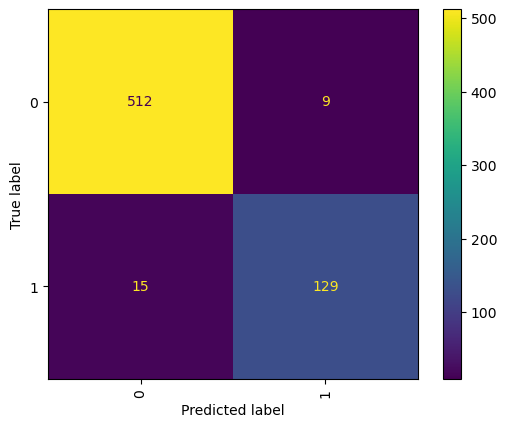

In [34]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(best_model_lr, X_valid, y_valid, xticks_rotation="vertical")

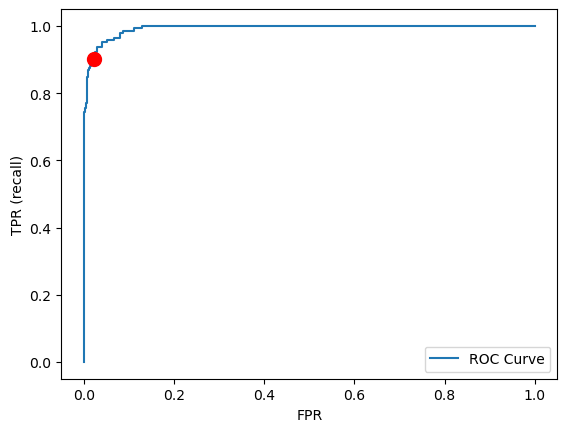

In [40]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_valid, best_model_lr.predict_proba(X_valid)[:, 1])
plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")

default_threshold = np.argmin(np.abs(thresholds - 0.4))

plt.plot(
    fpr[default_threshold],
    tpr[default_threshold],
    "or",
    markersize=10,
    # label="threshold 0.5",
)
plt.legend(loc="best");

In [43]:
from sklearn.metrics import confusion_matrix

proba = best_model_lr.predict_proba(X_valid)[:, 1]
proba

array([9.99983217e-01, 1.39401179e-04, 5.56896440e-05, 6.61203074e-07,
       9.92848565e-01, 3.54492201e-04, 4.80404322e-05, 2.66988656e-02,
       2.10738683e-01, 9.99376675e-01, 1.23267968e-06, 9.85103623e-01,
       9.74082179e-05, 9.24298227e-05, 2.83962197e-02, 4.95094490e-04,
       1.37532805e-04, 5.09802390e-06, 9.53581447e-01, 1.78469325e-04,
       1.58217648e-04, 3.44990396e-05, 1.91340964e-04, 3.43460713e-06,
       1.05437969e-04, 1.88852869e-06, 7.05769657e-01, 2.00937870e-05,
       1.38483093e-04, 1.09768903e-06, 9.24531038e-02, 1.67220596e-03,
       4.67456967e-03, 2.61207804e-06, 2.20952921e-05, 5.22687940e-05,
       7.95033284e-01, 7.31324666e-06, 9.99997229e-01, 1.90834548e-05,
       8.91854870e-09, 1.68430467e-05, 6.05873533e-01, 9.99913011e-01,
       9.99750718e-01, 9.06359551e-08, 2.11182142e-01, 1.12124240e-01,
       2.41633789e-06, 1.22851711e-07, 1.47079554e-01, 1.73238360e-02,
       9.99533290e-01, 9.57322974e-06, 8.03075544e-07, 9.99775252e-01,
      

In [45]:
predictions = np.array([1 if prob >= 0.4 else 0 for prob in proba])
predictions

array([1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,

In [57]:
proba = best_model_lr.predict_proba(X_valid)[:, 1]
predictions = np.array([1 if prob >= 0.5 else 0 for prob in proba])
TN, FP, FN, TP = confusion_matrix(y_valid, predictions).ravel()
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1_score = (2 * precision * recall) / (precision + recall)
print("valid:", precision, recall, f1_score)

proba = best_model_lr.predict_proba(X_test)[:, 1]
predictions = np.array([1 if prob >= 0.5 else 0 for prob in proba])
TN, FP, FN, TP = confusion_matrix(y_test, predictions).ravel()
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1_score = (2 * precision * recall) / (precision + recall)
print("test", precision, recall, f1_score)

proba = best_model_lr.predict_proba(X_valid)[:, 1]
predictions = np.array([1 if prob >= 0.3 else 0 for prob in proba])
TN, FP, FN, TP = confusion_matrix(y_valid, predictions).ravel()
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1_score = (2 * precision * recall) / (precision + recall)
print("valid:", precision, recall, f1_score)

proba = best_model_lr.predict_proba(X_test)[:, 1]
predictions = np.array([1 if prob >= 0.3 else 0 for prob in proba])
TN, FP, FN, TP = confusion_matrix(y_test, predictions).ravel()
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1_score = (2 * precision * recall) / (precision + recall)
print("test", precision, recall, f1_score)


valid: 0.9347826086956522 0.8958333333333334 0.9148936170212766
test 0.9302325581395349 0.8823529411764706 0.9056603773584906
valid: 0.9047619047619048 0.9236111111111112 0.914089347079038
test 0.8857142857142857 0.9117647058823529 0.8985507246376812


12

### 6.2 Logistic Regression Coefficients

In [48]:
data = {
    "coefficient": best_model_lr.named_steps['logisticregression'].coef_.flatten().tolist(),
    "magnitude": np.absolute(
        best_model_lr.named_steps['logisticregression'].coef_.flatten().tolist()
    ),
}
coef_df = pd.DataFrame(data, index=col_names).sort_values(
    "magnitude", ascending=False
)

In [60]:
# Top 30 features contributing for positive class
coef_df.query('coefficient > 0').head(30)

,coefficient,magnitude
archeology,0.706139,0.706139
362,0.409398,0.409398
earth,0.372142,0.372142
581,0.365279,0.365279
334,0.363596,0.363596
732,0.340034,0.340034
205,0.327196,0.327196
155,0.311393,0.311393
planetary,0.309648,0.309648
445,0.307805,0.307805


In [49]:
# Top 30 features contributing for negative class
coef_df.query('coefficient < 0').head(30)

,coefficient,magnitude
718,-0.454903,0.454903
761,-0.399649,0.399649
multidisciplinary,-0.367988,0.367988
55,-0.357287,0.357287
723,-0.356060,0.356060
393,-0.340309,0.340309
202,-0.330392,0.330392
462,-0.309048,0.309048
125,-0.294865,0.294865
466,-0.288371,0.288371


### 6.3 Interpreting the key word embeddings

> Embedding 362 : The larger the embedding, the more likely the article is relevant.

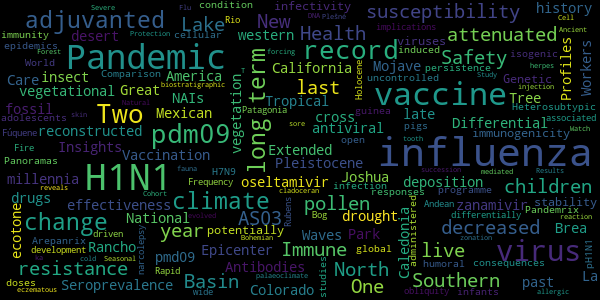

In [88]:
text_362_high = " ".join(train_df.sort_values(by = '362', ascending = False).head(20)['text_with_abstract'].tolist())
wordcloud = WordCloud(max_font_size=40, width=600, height=300)
wordcloud.generate(text_362_high).to_image()

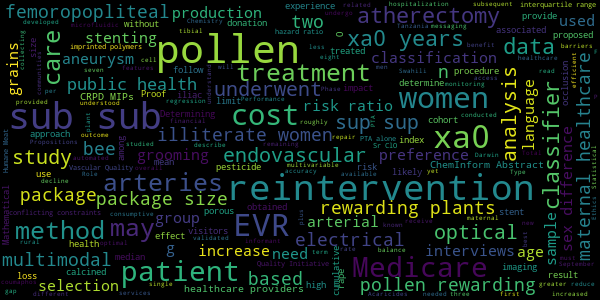

In [90]:
text_362_low = " ".join(train_df.sort_values(by = '362', ascending = False).tail(20)['text_with_abstract'].tolist())
wordcloud = WordCloud(max_font_size=40, width=600, height=300)
wordcloud.generate(text_362_low).to_image()

> Embedding 718: The more negative the value is, the more likely the article is relevant.

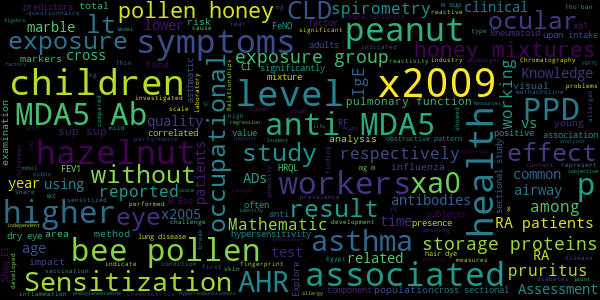

In [63]:
text_718_high = " ".join(train_df.sort_values(by = '718', ascending = False).head(20)['text_with_abstract'].tolist())
wordcloud = WordCloud(max_font_size=40, width=600, height=300)
wordcloud.generate(text_718_high).to_image()

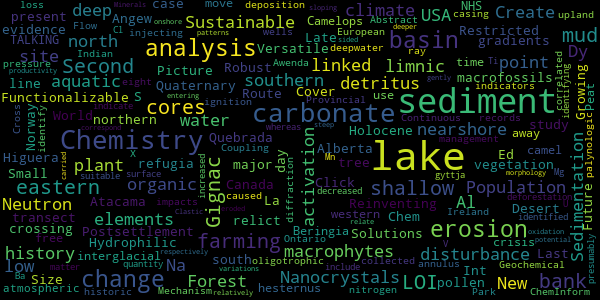

In [64]:
text_718_low = " ".join(train_df.sort_values(by = '718', ascending = False).tail(20)['text_with_abstract'].tolist())
wordcloud = WordCloud(max_font_size=40, width=600, height=300)
wordcloud.generate(text_718_low).to_image()

### 6.4 Case-by-case investigation

In [76]:
predictions = best_model_lr.predict(X_test)
probs = best_model_lr.predict_proba(X_test)
test_df['predictions'] = predictions
test_df['pred_proba_1'] = probs[:, 1]

In [81]:
# False Positives
test_df.query('target == 0 & predictions == 1')

,is-referenced-by-count,has_abstract,subject_clean,text_with_abstract,target,0,1,2,3,4,...,760,761,762,763,764,765,766,767,predictions,pred_proba_1
4392,8,1,Immunology Immunology and Allergy,"Climate change, airborne pollen, and pollution",0,0.286190,-0.185846,0.816835,0.203684,0.401631,...,0.410998,-0.889461,-0.364534,-0.207057,-0.299254,-0.281543,-0.260581,-0.794059,1,0.784324
2686,12,1,Multidisciplinary,Evidence grows that peopling of the Americas b...,0,0.040969,0.548009,0.120604,0.094556,0.681848,...,-0.008162,-0.781698,-0.021897,-0.204032,-0.477088,0.273001,-0.644550,-0.298202,1,0.501312
3952,2,0,"Plant Science Ecology Ecology, Evolution, Beha...",Taxon Cycles in Neotropical Mangroves The con...,0,0.588416,-0.053824,-0.050785,0.251222,0.885861,...,0.301806,-0.701965,-0.017652,-0.556827,-0.672958,0.030318,-0.180302,-0.722493,1,0.820017
2182,6,1,General Earth and Planetary Sciences,A Space-Time Raster GIS Data Model for Spatiot...,0,0.375969,-0.532317,0.283390,0.009962,0.677625,...,0.644118,-1.023055,-0.541022,-0.282278,-0.336280,-0.168137,0.022882,-0.405805,1,0.545247
3168,36,0,"Anthropology Ecology, Evolution, Behavior and ...",Stable isotope paleoecology of Late Pleistocen...,0,0.687200,0.038780,-0.276628,-0.181212,0.665542,...,0.420955,-0.682726,-0.282745,-0.406084,-0.203722,0.075537,0.023365,-0.889069,1,0.872077
3076,22,0,"Anthropology Ecology, Evolution, Behavior and ...",Hominin diversity and high environmental varia...,0,0.376971,0.298666,-0.116250,0.217207,0.566766,...,0.441397,-0.627667,-0.192676,-0.510259,-0.341850,0.050095,-0.157582,-0.771408,1,0.595572
3566,10,0,"Library and Information Sciences Statistics, P...",A statistics-based reconstruction of high-reso...,0,-0.151691,0.001149,0.126745,0.233115,0.353917,...,0.601525,-1.029252,-0.046918,-0.530886,-0.370243,0.185384,-0.026844,-0.558948,1,0.779811
2627,1,0,Multidisciplinary,"Settlement, environment, and climate change in...",0,-0.011859,0.451700,0.266275,0.226864,0.731320,...,0.319172,-0.649614,-0.310891,-0.415376,-0.580483,-0.232780,-0.078169,-0.711891,1,0.565869
2942,28,0,Multidisciplinary,Using artificial neural networks to predict fu...,0,0.877768,-0.183808,0.479890,0.391845,0.721149,...,-0.119612,-0.677910,-0.173062,-0.555423,-0.100679,-0.292753,-0.223760,-0.798118,1,0.833220
3300,9,1,Multidisciplinary,Tropical forests as key sites of the “Anthropo...,0,0.775731,0.342960,-0.285565,0.015088,0.498305,...,-0.017006,-1.405690,-0.211421,-1.061171,-0.508970,0.321076,-0.458389,-0.622318,1,0.935645


In [83]:
# False Negative
test_df.query('target == 1 & predictions == 0')

,is-referenced-by-count,has_abstract,subject_clean,text_with_abstract,target,0,1,2,3,4,...,760,761,762,763,764,765,766,767,predictions,pred_proba_1
148,35,1,"Paleontology Ecology, Evolution, Behavior and ...",A general framework for determining cutoff val...,1,0.403553,-0.165895,-0.270389,-0.181532,0.586620,...,0.067820,-1.073519,-0.334076,-0.434081,-0.712888,-0.471258,-0.501174,-0.776501,0,0.209220
3672,5,0,"Anthropology Ecology, Evolution, Behavior and ...",Site occupation dynamics of early modern human...,1,0.449283,0.267687,-0.048953,-0.130643,0.260929,...,0.453800,-1.004357,-0.489579,-0.351018,-0.225813,-0.421883,-0.211135,-0.767873,0,0.119635
601,2,0,Museology Archeology Arts and Humanities (misc...,Bison Jump Location is Primarily Predicted by ...,1,0.023915,0.001134,-0.267594,0.174491,0.474875,...,0.059761,-0.348451,-0.245038,-0.745947,-0.392388,-0.418747,-0.326066,-0.626413,0,0.117389
3399,0,0,Plant Science,Fossil pollen resolves origin of the South Afr...,1,0.799006,0.072416,0.167970,-0.102468,0.250834,...,0.315138,-0.389148,0.214994,-0.946495,-0.506957,0.467604,0.129413,-0.569880,0,0.292967
3479,0,0,Plant Science,Reclamation in southern China: The early Chu’s...,1,0.014343,0.115062,0.080461,0.251837,0.596370,...,0.068936,-0.831402,-0.921576,-0.798327,-0.674365,-0.005099,0.477557,-0.637627,0,0.197820
3154,2,0,Pollution Waste Management and Disposal Enviro...,Alkalinity and diatom assemblages in lowland s...,1,0.294494,-0.140384,0.134414,0.501923,0.630669,...,0.408172,-1.004594,-0.331516,-0.397120,-0.502169,-0.061922,-0.856465,-0.735245,0,0.127051
3445,33,0,"Anthropology Ecology, Evolution, Behavior and ...","Site fragmentation, hominin mobility and LCT v...",1,0.581317,0.072892,0.083648,0.177843,0.331097,...,0.348751,-0.771030,-0.174872,-0.519469,-0.447008,-0.180165,-0.060099,-0.667517,0,0.066829
632,32,1,Pollution Water Science and Technology Ecologi...,Algal microfossils provide high temporal resol...,1,-0.098108,-0.314832,0.291335,0.416009,-0.039419,...,0.503636,-1.062106,-0.152788,-0.544149,-0.163031,0.502594,-0.052568,-0.303113,0,0.477687
2740,0,0,Plant Science,Plant foods consumed at the Neolithic site of ...,1,0.148074,0.284149,-0.096527,0.522842,0.446091,...,0.346000,-0.751778,-0.812339,-0.725044,-1.012209,-0.261725,0.081585,-0.773659,0,0.193070
2953,27,0,"Anthropology Ecology, Evolution, Behavior and ...",Climatic controls on Later Stone Age human ada...,1,0.660950,0.044681,0.056798,0.072120,0.619098,...,0.282105,-0.538795,-0.062408,-0.603031,-0.046796,-0.269328,-0.032215,-0.657981,0,0.097578
